# Sentinel 3 Validation Team Australia - Analysis of Hotspots

In [1]:
import gc
import matplotlib.pyplot as plt
import seaborn
import boto3
from botocore.exceptions import ClientError
from netCDF4 import Dataset
import datetime as dt
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import shapely.speedups
shapely.speedups.enable()
#import xmltodict
import yaml
import os
import subprocess
from datetime import date
from datetime import datetime
from datetime import timedelta
import logging
logger = logging.getLogger()
import os
import netCDF4
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
from geopy.distance import distance
from pathlib import Path
import shutil
import requests
from requests.auth import HTTPBasicAuth
import folium
import json
import joblib
import time




In [2]:
#import time
#from dask.distributed import Client

# If you want Dask to set itself up on your personal computer
#client = Client(processes=False)
#client

In [3]:
logger.setLevel(level=logging.INFO)
logging.basicConfig(filename='notebook.log',level=logging.INFO)

# Open configuration file and read parameters

In [4]:
with open(r'config.yaml') as file:
    configuration =  yaml.load(file, Loader=yaml.FullLoader)

In [5]:
for config in configuration['configurations']:
    username = config['username']
    password = config['password']
    url = config['url']
    aoi = config['aoi']
    awss3bucket = config['awss3bucket']
    awskeyid = config['awskeyid']
    awskeypass = config['awskeypass']
    hotspotslogin = config['hotspots_login']
    hotspotspassword = config['hotspots_password']


# Functions

In [6]:
def get_satellite_swaths(configuration, start, period, solar_day):
    """
    Function to determine the common imaging footprint of a pair of sensors
    
    Returns the imaging footprints of a pair of sensors for a period from a starting datetime
    """
    output = Path('output')
    dirpath = Path.joinpath(output, solar_day)
    
    if (dirpath.exists()):
        logger.info(str(solar_day)+" exists - skipping swath generation")
        success = True
    else:
        dirpath.mkdir(parents=True, exist_ok=True)

    
        try:
            logger.info('Generating swaths '+str(['python', 'swathpredict.py', '--configuration', configuration, '--start', start, '--period', period, '--output_path', str(dirpath)])
)
            subprocess.call(['python', 'swathpredict.py', '--configuration', configuration, '--start', start, '--period', period, '--output_path', str(dirpath)])
            
            success = True
        except:
            success = False
            logger.info('Swath generation failed')
    
    return(success)

In [7]:
def pairwise_swath_intersect(satsensorsA, satsensorsB, solar_day):
    """
    Function intersect geometries of sensors for a given solar day 
    
    Returns intersection geometry
    """
    logging.info("Running intersection for "+str(satsensorsA)+' '+str(satsensorsB))
    satsensorsA = [w.replace(' ', '_') for w in satsensorsA]
    satsensorsB = [w.replace(' ', '_') for w in satsensorsB]
        
    filesA = []
    filesB = []
    
    output = Path('output')
    dirpath = Path.joinpath(output, solar_day)
    
    for sat in satsensorsA:
   
        filesA.extend([f for f in os.listdir(str(dirpath)) if (sat in f )and ('swath.geojson' in f)])
        
    for sat in satsensorsB:
    
        filesB.extend([f for f in os.listdir(str(dirpath)) if sat in f and 'swath.geojson' in f])
    
    gpdlistA = []
    for file in filesA:
        df = gpd.read_file(Path.joinpath(dirpath, file))
        gpdlistA.append(df)
    gpdlistB = []
    for file in filesB:
        df = gpd.read_file(Path.joinpath(dirpath, file))
        gpdlistB.append(df)        
    return(pd.concat(gpdlistA),pd.concat(gpdlistB) )

In [8]:
def solar_day_start_stop_period(longitude_east, longitude_west, solar_day):
    """
    Function solar day start time from longitude and solar day in utc 
    
    Returns datetime start stop in utc and period between in minutes
    """
    # Solar day time relative to UTC and local longitude
    SECONDS_PER_DEGREE = 240
    # Offset for eastern limb
    offset_seconds_east = int(longitude_east * SECONDS_PER_DEGREE)
    offset_seconds_east = np.timedelta64(offset_seconds_east, 's')
    # offset for wester limb
    offset_seconds_west = int(longitude_west * SECONDS_PER_DEGREE)
    offset_seconds_west = np.timedelta64(offset_seconds_west, 's')
    # time between two limbs
    offset_day = np.timedelta64(1440, 'm') + abs(offset_seconds_east - offset_seconds_west)
    #ten_am_crossing_adjustment = np.timedelta64(120, 'm')
    # Solar day start at eastern limb
    solar_day_start_utc = (np.datetime64(solar_day) - offset_seconds_east ).astype(datetime)
    # Solar day finish at western limb
    solar_day_finish_utc = ((np.datetime64(solar_day)+offset_day)  - offset_seconds_east ).astype(datetime)
    # Duration of solar day
    solar_day_duration = np.timedelta64((solar_day_finish_utc - solar_day_start_utc), 'm' )
    
    return(solar_day_start_utc, solar_day_finish_utc , solar_day_duration.astype(datetime))

In [9]:
def solar_day(utc, longitude):
    """
    Function solar day for a given UTC time and longitude input
    
    Returns datetime object representing solar day
    """
    SECONDS_PER_DEGREE = 240
    offset_seconds = int(longitude * SECONDS_PER_DEGREE)
    offset = np.timedelta64(offset_seconds, 's')
    return (np.datetime64(utc) + offset).astype(datetime)

In [10]:
def ckdnearest(gdA, gdB):
    """
    Function to find points in "B" nearest to "A" geopandas dataframe
    
    Returns geopandas dataframe with records representing matches
    """
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = gpd.GeoDataFrame(pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx].reset_index(drop=True).add_prefix('2_'),
         pd.Series(dist, name='dist')], axis=1))
    return gdf

In [11]:
def plot(df, column_name, ax,  bounds, cmap='jet', title=''):
    poly = Polygon.from_bounds(*bounds)
    df_clipped = gpd.clip(df, poly)
    df_clipped.plot(markersize=0.1, column=column_name, ax=ax)
    ax.set_title(title)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    bound_subset = gpd.clip(world, poly)
    bound_subset.to_crs(df.crs).plot(ax=ax, color='none', edgecolor='black')

# Spatial and temporal area of interest

In [12]:
# Set the area of interest
# Scenario 1 - all of Australia
#westlon = 110.0
#southlat = -50.0
#eastlon = 160.0
#northlat = -10.0
#bbox = (westlon, southlat, eastlon, northlat)
#start_date = '2019-11-01'
#end_date = '2020-05-01'

In [13]:
# Scenario 2 - NSW AOI determine by NSW RFS burnt area Isochrons
westlon = 147
southlat = -38
eastlon = 154
northlat = -27
bbox = (westlon, southlat, eastlon, northlat)
start_date = '2019-11-01'
end_date = '2020-10-8'

In [ ]:
# Download Hotpots files from AWS S3 to local 

In [14]:
# Ensure you're within the s3vt repository s3vt/ 
if os.path.exists("DEAHotspots_hotspots.geojson"):
    print('exists')
else:
    ! aws s3 cp s3://s3vtaustralia/DEAHotspots.geojson DEAHotspots_hotspots.geojson 

exists


In [15]:
if os.path.exists("s3vt_hotspots.geojson"):
    print('exists')
else:
    ! aws s3 cp s3://s3vtaustralia/s3vt_hotspots.geojson s3vt_hotspots.geojson

exists


In [16]:
# This one needs updating for new ESA hotspots ##TODO
if os.path.exists("s3vt_eumetsat_hotspots.geojson"):
    print('exists')
else:
    ! aws s3 cp s3://s3vtaustralia/s3vt_eumetsat_hotspots.geojson s3vt_eumetsat_hotspots.geojson

exists


In [17]:
if os.path.exists("nasa_hotspots_gdf.geojson"):
    print('exists')
else:
    ! aws s3 cp s3://s3vtaustralia/nasa_hotspots_gdf.geojson nasa_hotspots_gdf.geojson

exists


In [18]:
# This one needs updating for ESA hotspots
if os.path.exists("landgate_hotspots_gdf.geojson"):
    print('exists')
else:
    ! aws s3 cp s3://s3vtaustralia/landgate_hotspots_gdf.geojson landgate_hotspots_gdf.geojson

exists


# Load Hotspots to GeoPandas

In [ ]:
dea_hotspot_gdf = gpd.read_file('DEAHotspots_hotspots.geojson', bbox=bbox)
dea_hotspot_gdf['datetime'] = pd.to_datetime(dea_hotspot_gdf['datetime'])
dea_hotspot_gdf['solar_day'] = pd.to_datetime(dea_hotspot_gdf['solar_day'])
dea_hotspot_gdf['power'] = dea_hotspot_gdf['power'].astype('float32')   # power was not in floating point 
dea_hotspot_gdf['satellite_sensor_product'] = dea_hotspot_gdf['satellite']+'_'+dea_hotspot_gdf['sensor']+'_'+dea_hotspot_gdf['product']


In [ ]:
# Exclude known bad passes from DEA Hotspots
deleted_DEA_hotspots = pd.read_csv('Potential_FHS_to_be_deleted_from_DEA_Hotspots.csv')

In [ ]:
deleted_DEA_hotspots['datetime'] = pd.to_datetime(deleted_DEA_hotspots['datetime']) 

In [ ]:
dea_hotspot_gdf.loc[start_date:end_date]

In [ ]:
dea_hotspot_gdf_bup = dea_hotspot_gdf

In [ ]:
dea_hotspot_gdf.product

In [ ]:
dea_hotspot_gdf =  dea_hotspot_gdf.set_index(pd.DatetimeIndex(dea_hotspot_gdf.datetime.values))

In [ ]:
for index, row in deleted_DEA_hotspots.iterrows():

    example_date = row['datetime'].date()
    print(str(row['datetime'].date()))#== deleted_DEA_hotspots['datetime'][0].date()
    
    try:
        sensor_gdf = dea_hotspot_gdf[(dea_hotspot_gdf['satellite'] == row['satellite'])]
    
        sensor_gdf.set_index(pd.DatetimeIndex(sensor_gdf.datetime.values))
        example_date = (str(row['datetime'].date()))
        dates = sensor_gdf.loc[str(row['datetime'].date())]
    
        indexNames = dea_hotspot_gdf.loc[str(row['datetime'].date())][(dea_hotspot_gdf['satellite'] == row['satellite'])].index

        dea_hotspot_gdf.drop(indexNames , inplace=True)
    except:
        print("no data for this time")

In [ ]:
sensor_gdf.set_index(pd.DatetimeIndex(sensor_gdf.datetime.values))
sensor_gdf
#sensor_gdf.iloc[example_date]

In [ ]:
dea_hotspot_gdf = dea_hotspot_gdf_bup

In [19]:
nasa_hotspots_gdf = gpd.read_file('nasa_hotspots_gdf.geojson', bbox=bbox)
nasa_hotspots_gdf['datetime'] = pd.to_datetime(nasa_hotspots_gdf['datetime'])
nasa_hotspots_gdf['solar_day'] = pd.to_datetime(nasa_hotspots_gdf['solar_day'])

In [20]:
landgate_hotspots_gdf = gpd.read_file('landgate_hotspots_gdf.geojson', bbox=bbox)
landgate_hotspots_gdf['datetime'] = pd.to_datetime(landgate_hotspots_gdf['datetime'])
landgate_hotspots_gdf['solar_day'] = pd.to_datetime(landgate_hotspots_gdf['solar_day'])

In [21]:
esa_hotspot_gdf = gpd.read_file('s3vt_hotspots.geojson', bbox=bbox)
esa_hotspot_gdf['datetime'] = pd.to_datetime(esa_hotspot_gdf['date'])
esa_hotspot_gdf['solar_day'] = pd.to_datetime(esa_hotspot_gdf['solar_day'])
esa_hotspot_gdf['satellite_sensor_product'] = esa_hotspot_gdf['satellite']+'_'+esa_hotspot_gdf['sensor']+'_ESA'

In [22]:
eumetsat_hotspot_gdf = gpd.read_file('s3vt_eumetsat_hotspots.geojson', bbox=bbox)
eumetsat_hotspot_gdf['datetime'] = pd.to_datetime(eumetsat_hotspot_gdf['date'])
eumetsat_hotspot_gdf['solar_day'] = pd.to_datetime(eumetsat_hotspot_gdf['solar_day'])
# TODO - fix the below update in geojson creation
eumetsat_hotspot_gdf = eumetsat_hotspot_gdf.replace('SENTINEL_S3A', 'SENTINEL_3A')
eumetsat_hotspot_gdf = eumetsat_hotspot_gdf.replace('SENTINEL_S3B', 'SENTINEL_3B')
eumetsat_hotspot_gdf['satellite_sensor_product'] = eumetsat_hotspot_gdf['satellite']+'_'+eumetsat_hotspot_gdf['sensor']+'_EUMETSAT'


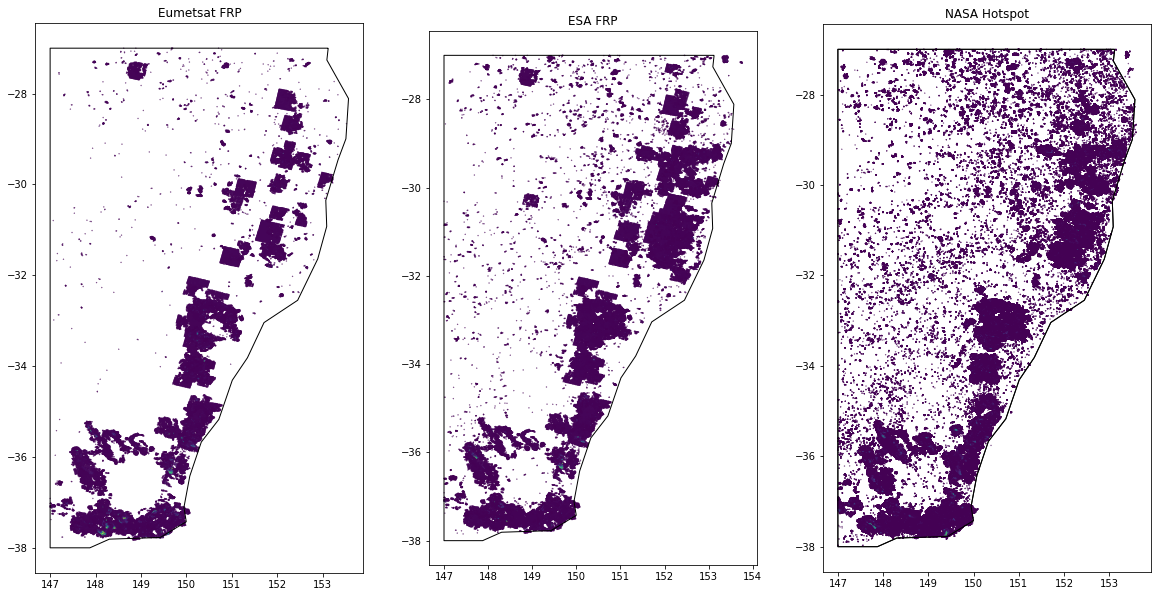

In [25]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 12))
plot(eumetsat_hotspot_gdf, 'F1_Fire_pixel_radiance', axs[0],  bbox, cmap='jet', title=f'Eumetsat FRP')
plot(esa_hotspot_gdf, 'F1_Fire_pixel_radiance', axs[1],  bbox, cmap='jet', title=f'ESA FRP')
plot(landgate_hotspots_gdf, 'power', axs[2],  bbox, cmap='jet', title=f'Landgate Hotspot')
plot(nasa_hotspots_gdf, 'power', axs[2],  bbox, cmap='jet', title=f'NASA Hotspot')

# Clean up S3 Hotspots to allow single GeoDataFrame

In [26]:
esa_hotspot_gdf.rename(columns={'F1_Fire_pixel_radiance':'power'}, inplace=True)
eumetsat_hotspot_gdf.rename(columns={'F1_Fire_pixel_radiance':'power'}, inplace=True)

In [27]:
esa_hotspot_gdf = esa_hotspot_gdf.drop(['FRP_MWIR', 'FRP_SWIR', 'FRP_uncertainty_MWIR',
       'FRP_uncertainty_SWIR', 'Glint_angle', 'IFOV_area', 'Radiance_window',
       'S7_Fire_pixel_radiance', 'TCWV', 'classification',  'i',
       'j', 'n_SWIR_fire', 'n_cloud', 'n_water',
       'n_window', 'time', 'transmittance_MWIR', 'transmittance_SWIR',
       'used_channel', 'date'], axis=1)
eumetsat_hotspot_gdf = eumetsat_hotspot_gdf.drop(['FRP_MWIR', 'FRP_SWIR', 'FRP_uncertainty_MWIR',
       'FLAG_SWIR_SAA', 'FRP_uncertainty_SWIR', 'Glint_angle', 'IFOV_area', 'Radiance_window',
       'S7_Fire_pixel_radiance', 'TCWV', 'classification',  'i',
       'j', 'n_SWIR_fire', 'n_cloud', 'n_water',
       'n_window', 'time', 'transmittance_MWIR', 'transmittance_SWIR',
       'used_channel', 'date'], axis=1)

In [28]:
esa_hotspot_gdf['satellite_sensor_product'] = esa_hotspot_gdf['satellite']+'_'+esa_hotspot_gdf ['sensor']+'_ESA'

In [29]:
eumetsat_hotspot_gdf['satellite_sensor_product'] = eumetsat_hotspot_gdf['satellite']+'_'+eumetsat_hotspot_gdf ['sensor']+'_EUMETSAT'

In [ ]:
dea_hotspot_gdf['satellite_sensor_product'] = dea_hotspot_gdf['satellite']+'_'+dea_hotspot_gdf['sensor']+'_'+dea_hotspot_gdf['product']

In [ ]:
dea_hotspot_gdf = dea_hotspot_gdf.drop(['product'], axis=1)

In [ ]:
hotspots_gdf = pd.concat([dea_hotspot_gdf, eumetsat_hotspot_gdf,esa_hotspot_gdf ])

In [30]:
hotspots_gdf = pd.concat([nasa_hotspots_gdf,landgate_hotspots_gdf, eumetsat_hotspot_gdf,esa_hotspot_gdf ])

In [ ]:
# Empty the S3 geodataframe object
eumetsat_hotspot_gdf = None
esa_hotspot_gdf = None
dea_hotspot_gdf = None
gc.collect()

In [31]:
# Concatenating doesn't update the index automatically
hotspots_gdf.reset_index(drop=True, inplace=True)

# Index by solar day to enable groupby

In [32]:
hotspots_gdf.index

RangeIndex(start=0, stop=3165058, step=1)

In [33]:
hotspots_gdf =  hotspots_gdf.set_index(pd.DatetimeIndex(hotspots_gdf.solar_day.values))

# Temporal subset (by solar day) to enable rapid testing

In [34]:
comparison_prefix = start_date+'_'+end_date
hotspots_gdf = hotspots_gdf.loc[start_date:end_date]

In [35]:
hotspots_gdf.loc[start_date:end_date]['datetime'].min(), hotspots_gdf.loc[start_date:end_date]['datetime'].max()

(Timestamp('2019-11-01 02:05:00'), Timestamp('2020-10-08 04:36:00'))

# Plot results

In [ ]:
# Map plot hotspots
hotspots_gdf.plot(column='satellite_sensor_product', legend=True, legend_kwds={'loc': 'upper right'}, figsize=(20, 20))

# Run comparison matrix

In [36]:
def compare_hotspots(productA, hotspots_gdf):
    """
    Function compares sensor swaths of productA to those of sensors in hotspots_gdf -subsets hotspots to
    common imaged area and determines points nearest to productA from hotspots_gdf. Computes distance between points.
    
    Returns dataframe containing matched pairs between the two sets of hotspots as w
    """
    appended_dataframe = []
    nearest_points_list = []
    satellite_sensor_product_intersections = {}
    for productB in set(hotspots_gdf['satellite_sensor_product']):

        gdfA = hotspots_gdf[(hotspots_gdf['satellite_sensor_product'] == productA)]       
        gdfB = hotspots_gdf[(hotspots_gdf['satellite_sensor_product'] == productB)]       

        # For each solar day group in gdfA
        for Aname, Agroup in gdfA.resample('D', on='solar_day'):

            minutctime, maxutctime, deltautctime = solar_day_start_stop_period(eastlon, westlon, Aname)

            # For each solar day group in gdfB
            for Bname, Bgroup in gdfB.resample('D', on='solar_day'):      

                # Do where the solar days are the same in gdfA and B
                if (Aname == Bname):
                    logger.info(productA+' '+productB)

                    logger.info(str(Aname)+' '+str(minutctime)+' '+str(minutctime)+' '+str(deltautctime))

                    # Generate the GeoJSON for each satellite in s3vtconfig.yaml

                    get_satellite_swaths('s3vtconfig.yaml', minutctime.strftime("%Y-%m-%dT%H:%M:%SZ"), str(int(deltautctime.total_seconds()/60)), str(Aname.date()))

                    # Geostationary satellites need an exception
                    if not (('AHI' in [productA, productB]) or ('INS1' in [productA, productB])):

                        # Include a try except to counteract failures where swath intersect fails
                        try:

                            # Get geometries for satellite sensors in gpdA and gpdB
                            gpd1, gpd2 = pairwise_swath_intersect(set(Agroup['satellite']), set(Bgroup['satellite']), str(Aname.date()))

                            # Union before intersect
                            gpd1 = gpd1.unary_union
                            gpd2 = gpd2.unary_union

                            # Intersect geometries
                            intersection = gpd1.intersection(gpd2)
                            logger.info(str(intersection))


                            if intersection == None:
                                logger.info("Intersection is None")
                            else:
                                logger.info("Intersection successful")
                            # Use intersection results to subset points (compare common imaged area)

                            logger.info("Before intersection "+str(Aname)+' '+str(Agroup['satellite_sensor_product'].count())+' '+str(Bgroup['satellite_sensor_product'].count()))

                            pip_mask = Agroup.within(intersection)
                            Agroup = Agroup.loc[pip_mask]                                
                            Agroup.reset_index(drop=True, inplace=True)

                            pip_mask = Bgroup.within(intersection)
                            Bgroup = Bgroup.loc[pip_mask]
                            Bgroup.reset_index(drop=True, inplace=True)
                            logger.info("After intersection "+str(Aname)+' '+str(Agroup['satellite_sensor_product'].count())+' '+str(Bgroup['satellite_sensor_product'].count()))

                            if (Agroup['solar_day'].count() == 0) or (Bgroup['solar_day'].count() == 0):
                                logger.info("Nothing to input to ckdnearest")

                            per_solarday_nearest_hotspots = ckdnearest(Agroup , Bgroup)

                            appended_dataframe.append(per_solarday_nearest_hotspots)

                        except:
                            logger.info('Skipping')
                    else:
                        # Himawari AHI or INS1 geostationary case
                        # A better approach here is to check if either has a swath available
                        # If not - defer to the intersection of the one with a geometry
                        # TODO - improve for Himawari
                        try:
                            per_solarday_nearest_hotspots = ckdnearest(Agroup.reset_index(drop=True, inplace=True), Bgroup.reset_index(drop=True, inplace=True))
                            print(len(appended_dataframe))
                            appended_dataframe.append(per_solarday_nearest_hotspots)
                            #per_solarday_nearest_hotspots.to_file(productA+'.geojson')
                        except:
                            logger.info('Skipping')
        try:
            
            nearest_points = gpd.GeoDataFrame( pd.concat( appended_dataframe, ignore_index=True) )
            nearest_points.reset_index(inplace=True, drop=True)

            outputfile = 'nearest_points.'+productA+'.csv'
            nearest_points.to_csv(outputfile)
        except Exception:
            logger.info('Nothing to concatenate')
        
    return(productA)

In [37]:
# Compare all hotspot sources to each other
# Option 1 - sequential processing
#for productA in set(hotspots_gdf['satellite_sensor_product']):
#    compare_hotspots(productA, hotspots_gdf)

In [ ]:
# Compare all hotspot sources to each other
# Option 2 - parallel processing
# Dask backend is having issues with memory leak to trying loky - limits options for outside memory but monthly partitions
# should provide an ok work around

nearest_points_list = []
appended_dataframe = []
satellite_sensor_product_intersections = {}
with joblib.parallel_backend('loky'):
    joblib.Parallel(verbose=100)(
        joblib.delayed(compare_hotspots)(productA, hotspots_gdf)
        for productA in set(hotspots_gdf['satellite_sensor_product']))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 93.6min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 247.3min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 258.4min


/env/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
import glob
from shapely import wkt
appended_dataframe = []
for inputfile in glob.glob('nearest_points*.csv'):
    print(inputfile)
    df = pd.read_csv(inputfile)
    geometry = df.geometry.apply(wkt.loads)
    df['dist_m'] = df.apply(lambda row: distance((row.latitude, row.longitude),(row['2_latitude'], row['2_longitude'])).meters, axis = 1)
    crs = 'epsg:4326'
    appended_dataframe.append(gpd.GeoDataFrame(df, crs=crs, geometry=geometry))

In [ ]:
#import dask.dataframe as dd
#nearest_points = dd.read_csv('nearest*.csv')

In [ ]:
nearest_points = gpd.GeoDataFrame(pd.concat(appended_dataframe))

In [ ]:
nearest_points['datetime'] = pd.to_datetime(nearest_points['datetime'])
nearest_points['solar_day'] = pd.to_datetime(nearest_points['solar_day'])
nearest_points['2_datetime'] = pd.to_datetime(nearest_points['2_datetime'])

In [ ]:
nearest_points['timedelta'] = (abs(nearest_points['datetime'] - nearest_points['2_datetime']))
nearest_points['count'] = 1

In [ ]:
# Add metres distance between two points
#nearest_points['dist_m'] = nearest_points.apply(lambda row: distance((row.latitude, row.longitude),(row['2_latitude'], row['2_longitude'])).meters, axis = 1)
# Add time delta between points
# nearest_points['timedelta'] = nearest_points.apply(lambda row: (abs(row['datetime'] - row['2_datetime'])), axis = 1)

In [ ]:
#output = comparison_prefix+'-'+'nearest_points.geojson'
#nearest_points.to_file(output, driver='GeoJSON')

In [ ]:
nearest_points.set_index('solar_day', inplace=True)

In [ ]:
australia = gpd.GeoDataFrame.from_file('zip://vectors/TM_WORLD_BORDERS_SIMPL-0.3.zip')

In [ ]:
australia = australia[australia.NAME=='Australia']

In [ ]:
# DEBUGGING For testing intersect results for swath and hotspots

satelliteA = 'SENTINEL_3B' # NOAA 19, NOAA 20, TERRA, AQUA, SENTINEL_3A, SENTINEL_3B
satelliteB = 'TERRA'
solar_date = '2020-04-10'
gpd1, gpd2 = pairwise_swath_intersect([satelliteA], [satelliteB], solar_date)

start_date = solar_date
end_date = solar_date
# uncomment below to examine data prior to intersect
hotspots_sample = hotspots_gdf.loc[start_date:end_date]

# uncomment below to examine data post intersect
#nearest_sample = nearest_points[(nearest_points['satellite'] == satelliteA) & (nearest_points['2_satellite'] == satelliteB) ]
#nearest_sample = pd.concat([nearest_sample, nearest_points[(nearest_points['satellite'] == satelliteB) & (nearest_points['2_satellite'] == satelliteA) ]])
#hotspots_sample = nearest_sample.loc[start_date:end_date]

fig, ax = plt.subplots(figsize=(15, 15))
gpd1.plot(ax=ax, facecolor='red');
gpd2.plot(ax=ax, color='green');
hotspots_sample[hotspots_sample['satellite'] == satelliteA].plot(ax=ax, color='tomato', markersize=2)
hotspots_sample[hotspots_sample['satellite'] == satelliteB].plot(ax=ax, color='lime', markersize=2)

gpd1int = gpd1.unary_union
gpd2int = gpd2.unary_union

intersection = gpd1int.intersection(gpd2int)

#intersection = intersection[~intersection.is_empty]
australia.plot(ax=ax, facecolor="None", edgecolor='white')
#gpd.GeoDataFrame(intersection).rename(columns={0:'geometry'}).set_geometry('geometry').plot(ax=ax, facecolor="None", edgecolor='black', hatch="///")
gpd.GeoDataFrame(gpd.GeoSeries(intersection)).rename(columns={0:'geometry'}).set_geometry('geometry').plot(ax=ax, facecolor="None", edgecolor='gray', hatch="///")
# Prepare for labels on GPD1
gpd1['coords'] = gpd1['geometry'].apply(lambda x: x.representative_point().coords[:])
gpd1['coords'] = [coords[0] for coords in gpd1['coords']]
for idx, row in gpd1.iterrows():
    plt.annotate(s=row['Transit time                 :'], xy=row['coords'], horizontalalignment='center')
# Plot it
plt.tight_layout()


In [ ]:
# Graph it to confirm intersect of swath and hotspots (all won't match - not hotspots in the sea etc.)
gpd1['Transit time                 :'] = pd.to_datetime(gpd1['Transit time                 :'])
df = hotspots_sample[(hotspots_sample['satellite'] == satelliteA)].sort_values('datetime', ascending=True)
dfswath = gpd1.sort_values('Transit time                 :', ascending=True)
plt.plot(df['datetime'], df['datetime'], '*', color='blue', markersize=10)
plt.plot(dfswath['Transit time                 :'], dfswath['Transit time                 :'], 'o', color='red', markersize=5)
plt.xticks(rotation='vertical')

In [ ]:
nearest_points['geometry'].count()

# Results
# Co-occurrence metrics

In [ ]:
# Count of hotspot matches < 5000m
numerator = pd.pivot_table(nearest_points[(nearest_points['dist_m'] < 5000)],values='count', index=['satellite_sensor_product'], columns=['2_satellite_sensor_product'], aggfunc={'count':len})

In [ ]:
# Count of hotspot matches - total
denominator = pd.pivot_table(nearest_points,values='count', index=['2_satellite_sensor_product'], columns=['satellite_sensor_product'], aggfunc={'count':np.sum})

In [ ]:
# Set seaborn styling for matrix
denominatortable = denominator.style.format("{:g}")
cm = seaborn.light_palette("blue", as_cmap=True)
s = denominatortable.background_gradient(cmap=cm)
s

In [ ]:
output = comparison_prefix+'-'+"matches_count.html"
html = open(output,"w")
html.write(s.render())
html.close()

In [ ]:
# Count of hotspot matches < 5000m
numerator = pd.pivot_table(nearest_points[(nearest_points['dist_m'] < 5000)],values='count', index=['2_satellite_sensor_product'], columns=['satellite_sensor_product'], aggfunc={'count':len})

In [ ]:
# Set seaborn styling for matrix
numeratortable = numerator.style.format("{:g}")
cm = seaborn.light_palette("red", as_cmap=True)
s = numeratortable.background_gradient(cmap=cm)
s

In [ ]:
output = comparison_prefix+'-'+"matches_5000m.html"
html = open(output,"w")
html.write(s.render())
html.close()

In [ ]:
# Percentage of matched points closer than 5000m
difference = (denominator - numerator).style.format("{:g}") 
# Set seaborn styling for matrix
cm = seaborn.light_palette("red", as_cmap=True)
s = difference.background_gradient(cmap=cm)
s

In [ ]:
output = comparison_prefix+'-'+"count_difference.html"
html = open(output,"w")
html.write(s.render())
html.close()

In [ ]:
# Percentage of matched points closer than 5000m
percentage = (numerator / denominator).style.format("{:.0%}") 

In [ ]:
# Set seaborn styling for matrix
cm = seaborn.light_palette("green", as_cmap=True)
s = percentage.background_gradient(cmap=cm)
s

In [ ]:
output = comparison_prefix+'-'+"percentage.html"
html = open(output,"w")
html.write(s.render())
html.close()

In [ ]:
# Maximum time between matched points < 5000m
timemax = pd.pivot_table(nearest_points[(nearest_points['dist_m'] < 5000)],values='timedelta', index=['satellite_sensor_product'], columns=['2_satellite_sensor_product'], aggfunc={'timedelta':np.max})
# Set seaborn styling for matrix
timemaxtable = timemax.style.format("{:}")
cm = seaborn.light_palette("gray", as_cmap=True)
s = timemaxtable.background_gradient(cmap=cm)
s

In [ ]:
output = comparison_prefix+'-'+"max_time_matched_points.html"
html = open(output,"w")
html.write(s.render(annot=True))
html.close()

In [ ]:
# Minimum time between matched points < 5000m
timemin = pd.pivot_table(nearest_points[(nearest_points['dist_m'] < 5000)],values='timedelta', index=['2_satellite_sensor_product'], columns=['satellite_sensor_product'], aggfunc={'timedelta':np.min})
 
# Set seaborn styling for matrix
timemintable = timemin.style.format("{:}")
cm = seaborn.light_palette("purple", as_cmap=True)
s = timemintable.background_gradient(cmap=cm)
s

In [ ]:
output = comparison_prefix+'-'+"min_time_matched_points.html"
html = open(output,"w")
html.write(s.render())
html.close()

In [ ]:
# Average distance (m) between matched points < 5000m
averagedist = pd.pivot_table(nearest_points[(nearest_points['dist_m'] < 5000)],values='dist_m', index=['2_satellite_sensor_product'], columns=['satellite_sensor_product'], aggfunc={'dist_m':np.mean})
# Set seaborn styling for matrix
averagedisttable = averagedist.style.format("{:}")
cm = seaborn.light_palette("olive", as_cmap=True)
s = averagedisttable.background_gradient(cmap=cm)
s

In [ ]:
output = comparison_prefix+'-'+"avg_distance_5000m.html"
html = open(output,"w")
html.write(s.render())
html.close()

In [ ]:
# Done - TODO polygon intersection (using satellite footprint tool and S3 geojson)
# TODO match available Landsat and Sentinel 2 datasets with hotspots
# TODO Use WCS to interact with GSKY for DEA data queries - https://gsky.readthedocs.io/en/latest/_notebook/Notebook_GSKY_WCS.html
# TODO run fire detection on Landsat and Sentinel 2 - update attributes
# Done - TODO rerun the nearest test with S3 as the primary, as well as DEA Hotspots.
# Done - TODO add Himawari Hotspots from SRSS and WFABBA.(Done - see config.yaml, added password and request handling, concatenated GPD added)
# Done - TODO add persistent hotspots and compare frequency of detection
# TODO - get feedback on the length of day between midnight on the east side and midnight on the west side

In [ ]:
# Questions to answer
# How to define coincidence?
# How to constrain results - based on confidence? and minimum allowable radius?
# Perhaps groupby time should be a moving window of two days or only look at matching hotspots first detected early in the day?

In [ ]:
# TODO - Add moving window function i.e shift solar day by x hours forward or back and redo analysis
# Done TODO - Add time delta for matches as well - average time delta might be a useful statistic
# Done TODO - Add product group attribute to DEA dataframe
# Done TODO roll this up to the nearest comparison to simplify product handling

In [ ]:
nearest_points.to_csv('nearest_points.csv')

In [ ]:
# TODO - improve Results presentation
# Plot time against count of matches
# Plot vectors from one hotspot source to its match
# TODO add vectors linking spots to their nearest

# Persistent Hotspot Comparison
Landgate developed a set of persistent hotspots  (v5.2) by associating recurrent hotspots with known heat sources (industrial activity). Knowledge of persistent hotspots are used here to provide a baseline for the ability of a given sensor to detect hotspots. 

Persistent hotspots, together with high resolution hotspot sources from Sentinel 2 MSI and Landsat Enhanced Thematic Mapper and Opertional Land Imager sensors are used here to validate hotspots from the AVHRR, VIIRS, MODIS and SLSTR instruments.  

In [ ]:
persistent_hotspots = gpd.GeoDataFrame.from_file('zip://vectors/Known non FHS - Version 5.2.zip/Version 5.2/known_non_FHS.shp')

In [ ]:
# TODO match DEA Hotspots to persistent hotspots
# TODO match S3VT Hotspots to persistent hotspots
# TODO how often do matched hotspots match with perisistent hotspots
# TODO - improved logging

In [ ]:
nearest_persistent = ckdnearest( hotspots_gdf, persistent_hotspots)

In [ ]:
nearest_persistent['count'] = 1

In [ ]:
nearest_persistent['dist_m'] = nearest_persistent.apply(lambda row: distance((row.latitude, row.longitude),(row['2_Latitude'], row['2_Longitude'])).meters, axis = 1)

In [ ]:
# Count of hotspot matches 
persistentcount = pd.pivot_table(nearest_persistent,values='count', index=['2_Comment'], columns=['satellite_sensor_product'], aggfunc={'count':np.sum})
#persistentcount
# Set seaborn styling for matrix
persistentcounttable = persistentcount.style.format("{:g}")
cm = seaborn.light_palette("orange", as_cmap=True)
s = persistentcounttable.background_gradient(cmap=cm)
s

In [ ]:
output = comparison_prefix+'-'+"persistent_matches.html"
html = open(output,"w")
html.write(s.render())
html.close()

In [ ]:
# Count of hotspot matches < 5000m
persistentcountm = pd.pivot_table(nearest_persistent[(nearest_persistent['dist_m'] < 5000)],values='count', index=['2_Comment'], columns=['satellite_sensor_product'], aggfunc={'count':np.sum})
# Set seaborn styling for matrix
persistentcountmtable = persistentcountm.style.format("{:g}")
cm = seaborn.light_palette("blue", as_cmap=True)
s = persistentcountmtable.background_gradient(cmap=cm)
s

In [ ]:
output = comparison_prefix+'-'+"peristent_matches_5000m.html"
html = open(output,"w")
html.write(s.render())
html.close()

In [ ]:
nearest_persistent['line_geometry'] = nearest_persistent.apply(lambda row: shapely.wkt.loads(LineString([row.geometry, row['2_geometry']]).wkt), axis = 1)

In [ ]:
nearest_persistent = nearest_persistent.set_geometry('line_geometry')

In [ ]:
nearest_persistent.geometry.plot(figsize=(20, 20))

In [ ]:
gjson = persistent_hotspots.geometry.to_crs(epsg='4326').to_json()

In [ ]:
mapa = folium.Map([-26, 132],
                  zoom_start=4,
                  tiles='Stamen Terrain')

points = folium.features.GeoJson(gjson)

mapa.add_child(points)
mapa

# Burnt Area Mapping Comparison 
Burnt area mapping comparisons to NSW Rural Fire Service isochrons drawn from aerial thermal line scanner and other high resolution sources.

In [ ]:
# Isochrons - burn history from RFS
rfs_isochrons = gpd.GeoDataFrame.from_file('zip://vectors/NSW_Isochrons_Progall_ffdi_v3.zip/progall_ffdi_v3.shp')
rfs_isochrons.crs = 'epsg:3308'
rfs_isochrons.to_crs('epsg:4326', inplace=True)
rfs_isochrons['time'] = pd.to_datetime(rfs_isochrons.time)
rfs_isochrons['time'] = rfs_isochrons['time'].dt.tz_localize(tz='Australia/Sydney')
rfs_isochrons['lasttim'] = pd.to_datetime(rfs_isochrons.lasttim)
rfs_isochrons['lasttim'] = rfs_isochrons['lasttim'].dt.tz_localize(tz='Australia/Sydney')
rfs_isochrons['solar_day'] = rfs_isochrons.apply(lambda row: solar_day(row.time, 150), axis = 1)
rfs_isochrons = rfs_isochrons.set_index(pd.DatetimeIndex(rfs_isochrons.solar_day.values))

In [ ]:
# Set the area of interest
westlon, southlat, eastlon, northlat = rfs_isochrons.total_bounds
bbox = (westlon, southlat, eastlon, northlat)

In [ ]:
isochrons = rfs_isochrons.geometry.to_json()
hotspots = hotspots_gdf.loc['2019-11-02':'2019-11-02'].geometry.to_json()

In [ ]:
mapa = folium.Map([-26, 132],
                  zoom_start=4,
                  tiles='Stamen Terrain')

points = folium.features.GeoJson(isochrons)
mapa.add_child(points)
points = folium.features.GeoJson(hotspots)
mapa.add_child(points)
mapa

In [ ]:
intersection_list = []
for Aname, Agroup in rfs_isochrons.resample('D', on='solar_day'):
    for Bname, Bgroup in hotspots_gdf.resample('D', on='solar_day'):
        if Aname == Bname:
            try:
                Agroup = Agroup.reset_index()
                Bgroup = Bgroup.reset_index()
                intersection = gpd.sjoin(Agroup, Bgroup, op='intersects')
                print(Aname, 'intersection success')
                intersection_list.append(intersection)
            except:
                print(Aname, 'intersection error')
            

In [ ]:
isochron_intersect = gpd.GeoDataFrame(pd.concat(intersection_list))

In [ ]:
isochron_intersect.reset_index()
isochron_intersect['count'] = 1

In [ ]:
isochron_intersect['solar_day'] = isochron_intersect.index

In [ ]:
isochron_intersect['solar_date'] = isochron_intersect.solar_day_right.dt.date

In [ ]:
pd.pivot_table(isochron_intersect, values='count', index=['solar_date'], columns=['satellite_sensor_product'], aggfunc={'count':np.sum})

# Discussion

# Conclusion